In [48]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.io import loadmat
from sklearn.utils import shuffle
from datetime import datetime

In [20]:
def y2indicator(y):
    N = len(y)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [4]:
def error_rate(p, t):
    return np.mean(p != t)

In [22]:
def flatten(X):
    N = X.shape[-1]
    flat = np.zeros((N, 3072))
    for i in range(N):
        flat[i] = X[:,:,:,i].reshape(3072)
    return flat

In [45]:
def get_data():
    if not os.path.exists('/home/schandrasekhar/datasets/large_dataset/housenumber/train_32x32.mat'):
        print('Looking for /home/schandrasekhar/datasets/large_dataset/housenumber/train_32x32.mat')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: http://ufldl.stanford.edu/housenumbers')
        print('Place train_32x32.mat and test_32x32.mat in the folder large_files adjacent to the class folder')
        exit()

    train = loadmat('/home/schandrasekhar/datasets/large_dataset/housenumber/train_32x32.mat')
    test  = loadmat('/home/schandrasekhar/datasets/large_dataset/housenumber/test_32x32.mat')
    return train, test

In [50]:
def main():
    train, test = get_data()
    

    # Need to scale! don't leave as 0..255
    # Y is a N x 1 matrix with values 1..10 (MATLAB indexes by 1)
    # So flatten it and make it 0..9
    # Also need indicator matrix for cost calculation
    Xtrain = flatten(train['X'].astype(np.float32) / 255.)
    Ytrain = train['y'].flatten() - 1
    Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

    Xtest  = flatten(test['X'].astype(np.float32) / 255.)
    Ytest  = test['y'].flatten() - 1

    # gradient descent params
    max_iter = 20
    print_period = 10
    N, D = Xtrain.shape
    batch_sz = 500
    n_batches = N // batch_sz

    # initial weights
    M1 = 1000 # hidden layer size
    M2 = 500
    K = 10
    W1_init = np.random.randn(D, M1) / np.sqrt(D + M1)
    b1_init = np.zeros(M1)
    W2_init = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
    b2_init = np.zeros(M2)
    W3_init = np.random.randn(M2, K) / np.sqrt(M2 + K)
    b3_init = np.zeros(K)

    # define variables and expressions
    X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    T = tf.placeholder(tf.int32, shape=(None,), name='T')
    W1 = tf.Variable(W1_init.astype(np.float32))
    b1 = tf.Variable(b1_init.astype(np.float32))
    W2 = tf.Variable(W2_init.astype(np.float32))
    b2 = tf.Variable(b2_init.astype(np.float32))
    W3 = tf.Variable(W3_init.astype(np.float32))
    b3 = tf.Variable(b3_init.astype(np.float32))

    Z1 = tf.nn.relu( tf.matmul(X, W1) + b1 )
    Z2 = tf.nn.relu( tf.matmul(Z1, W2) + b2 )
    logits = tf.matmul(Z2, W3) + b3

    cost = tf.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits,
            labels=T
        )
    )

    train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

    # we'll use this to calculate the error rate
    predict_op = tf.argmax(logits, 1)

    t0 = datetime.now()
    LL = []
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)

        for i in range(max_iter):
            for j in range(n_batches):
                Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
                Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz),]

                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest})
                    prediction = session.run(predict_op, feed_dict={X: Xtest})
                    err = error_rate(prediction, Ytest)
                    #print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                    LL.append(test_cost)
    print("Elapsed time:", (datetime.now() - t0))
    plt.plot(LL)
    plt.show()

Elapsed time: 0:05:14.423234


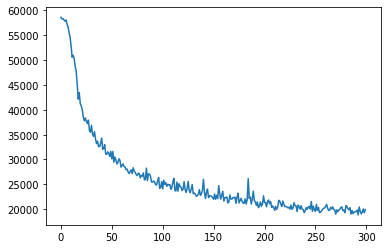

In [51]:

if __name__ == '__main__':
    main()
